# INTRODUCTION
This notebook contains sales forecasting model proof of concept and experiments for Briton and kay supermarket Oleh Branch
...

# LIBRARY IMPORTATION

In [4]:
#import data manipulation libraries
import os

import pandas as pd
import numpy as np
import pdfplumber
import pymupdf
from pdfquery import PDFQuery

import re

# import data visualization libraries
import seaborn as sns 
import matplotlib.pyplot as plt 

#models
from prophet import Prophet

#metrics
from sklearn.metrics import mean_squared_error


from pathlib import Path

# EXPLORATORY DATA ANALYSIS

### Importation of raw data

In [5]:
#raw data path
raw_data_path = Path.joinpath(Path.cwd().parent,"data/raw/details.pdf")

#create an empty list of dataframes
data_frames = []

try: 
    with pymupdf.open(raw_data_path) as pdf:
            sales_group = []
            for page_index, page in enumerate(pdf):
                rows=[]
                lines = page.get_text('blocks')
                date_pattern = r'\d{2}/\d{2}/\d{4}'
                for line in lines:
                    if line[0] == -0.2411675900220871:
                        split_lines = line[4].splitlines()
                        date_indices = [index  for index, element in enumerate(split_lines) if re.search(date_pattern, element)]
                        for index_number, index in enumerate(date_indices):
                            if index_number < len(date_indices)-1:
                                sales_group = split_lines[index:date_indices[index_number + 1]]
                            else:
                                sales_group = split_lines[index:]
                            if re.match(r'\D', sales_group[3]):
                                break
                            else:
                                sales_group.insert(3,'')
                            main_row = sales_group[:10]
                            #Retrieve groups of 4 elements after the 9th element
                            for i in range(10, len(sales_group), 4):
                                sub_row = sales_group[i:i + 4]  # Get a group of 4 elements
                                if len(sub_row) < 4:
                                    page_element = [element for element in sub_row  if re.search('page', element, re.IGNORECASE)]
                                    if page_element:
                                        break
                                    else:
                                        sub_row += [''] * (4 - len(sub_row))  # Pad with empty strings if fewer than 4 elements
                                    
                                rows.append(main_row + sub_row)
                # if page_index == 2:
                #      print('maximum page reached')
                #      break
                print(f'\r processed page {page_index + 1}', end=" ")  
                page_df = pd.DataFrame(rows, columns=['Date','Receipt_no', 'Receipt_type','Customer', 'Total_qnty', 
                                                    'Total_amount', 'Payment_type', 'Time', 'Cashpoint_number', 'Cashier', 
                                                            'item_no', 'product_name', 'quantity','amount'])
                data_frames.append(page_df)
except FileNotFoundError:
    print('\n file path does not exist')
except Exception as e :
    print(f'\n something went wrong: \n {e}')


 processed page 1603 

KeyboardInterrupt: 

In [ ]:
main_df = pd.concat(data_frames, ignore_index= True)
main_df.head(30)

,Date,Receipt_no,Receipt_type,Customer,Total_qnty,Total_amount,Payment_type,Time,Cashpoint_number,Cashier,item_no,product_name,quantity,amount
0,12/01/2022,437170,Sales,,1,600.00,Cash,10:10:31 pm,14,DIRECTOR,8893,KOLAQ ALAGBO BITTERS 200M,1,600.00
1,12/01/2022,437169,Sales,,2,470.00,Cash,10:10:08 pm,14,DIRECTOR,1405,COCA COLA PET 60CL,1,170.00
2,12/01/2022,437169,Sales,,2,470.00,Cash,10:10:08 pm,14,DIRECTOR,90,MCVITE'S DIGESTIVE 104G,1,300.00
3,12/01/2022,437168,Sales,,1,100.00,Cash,10:09:10 pm,14,DIRECTOR,7347,ROENEX SMALLEST PEANUTS,1,100.00
4,12/01/2022,437173,Sales,,2,"2,100.00",Debit Card,10:14:36 pm,14,DIRECTOR,2855,EASY ON SPRAY STARCH NEW,1,"1,500.00"
5,12/01/2022,437173,Sales,,2,"2,100.00",Debit Card,10:14:36 pm,14,DIRECTOR,4403,COLGATE NIG MAXI CAVITY P,1,600.00
6,12/01/2022,437172,Sales,,1,"1,500.00",Cash,10:11:50 pm,14,DIRECTOR,1686,RIGHT GUARD COOL SPRAY,1,"1,500.00"
7,12/01/2022,437171,Sales,,1,"1,840.00",Cash,10:11:05 pm,14,DIRECTOR,399,GOLDEN MORN 1kg,1,"1,840.00"
8,12/01/2022,437167,Sales,,1,600.00,Cash,10:08:52 pm,14,DIRECTOR,3743,VITAMILK DOUBLE CHOCO DR,1,600.00
9,12/01/2022,437163,Sales,,1,"2,300.00",Debit Card,10:06:41 pm,14,DIRECTOR,1721,BODY FANTASIES RASPBERRY,1,"2,300.00"


In [ ]:
main_df.shape

(337483, 14)

In [ ]:
#save impported dataframe to CSV
file_save_path = "data/processed/imported_oleh_sales_pymudf.csv"

imported_data_path = Path.joinpath(Path.cwd().parent,file_save_path)
main_df.to_csv(imported_data_path)

### Structural and Quality investigation

In [6]:
#import the save CSV
file_save_path = "data/processed/imported_oleh_sales_pymudf.csv"

imported_data_path = Path.joinpath(Path.cwd().parent,file_save_path)
import_df = pd.read_csv(imported_data_path, index_col=0, low_memory = False)

Overall structure of the imported dataframe 

In [7]:
import_df.head()

,Date,Receipt_no,Receipt_type,Customer,Total_qnty,Total_amount,Payment_type,Time,Cashpoint_number,Cashier,item_no,product_name,quantity,amount
0,12/01/2022,437170,Sales,NaN,1,600.00,Cash,10:10:31 pm,14,DIRECTOR,8893,KOLAQ ALAGBO BITTERS 200M,1,600.00
1,12/01/2022,437169,Sales,NaN,2,470.00,Cash,10:10:08 pm,14,DIRECTOR,1405,COCA COLA PET 60CL,1,170.00
2,12/01/2022,437169,Sales,NaN,2,470.00,Cash,10:10:08 pm,14,DIRECTOR,90,MCVITE'S DIGESTIVE 104G,1,300.00
3,12/01/2022,437168,Sales,NaN,1,100.00,Cash,10:09:10 pm,14,DIRECTOR,7347,ROENEX SMALLEST PEANUTS,1,100.00
4,12/01/2022,437173,Sales,NaN,2,"2,100.00",Debit Card,10:14:36 pm,14,DIRECTOR,2855,EASY ON SPRAY STARCH NEW,1,"1,500.00"


In [8]:
import_df.shape

(337483, 14)

Basic information of the dataframe, in terms of object type, count and column names

In [9]:
import_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 337483 entries, 0 to 337482
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              337483 non-null  object 
 1   Receipt_no        337483 non-null  int64  
 2   Receipt_type      337483 non-null  object 
 3   Customer          0 non-null       float64
 4   Total_qnty        337483 non-null  int64  
 5   Total_amount      337483 non-null  object 
 6   Payment_type      337179 non-null  object 
 7   Time              337483 non-null  object 
 8   Cashpoint_number  337483 non-null  int64  
 9   Cashier           337483 non-null  object 
 10  item_no           337483 non-null  int64  
 11  product_name      337483 non-null  object 
 12  quantity          337483 non-null  int64  
 13  amount            337483 non-null  object 
dtypes: float64(1), int64(5), object(8)
memory usage: 38.6+ MB


Based on the information from the data, the data type of some of the columns will have to corrected to ensure proper investigation and analysis can be done

Check for missing values

In [ ]:
import_df.isna().sum()

Date                     0
Receipt_no               0
Receipt_type             0
Customer            337483
Total_qnty               0
Total_amount             0
Payment_type           304
Time                     0
Cashpoint_number         0
Cashier                  0
item_no                  0
product_name             0
quantity                 0
amount                   0
dtype: int64

Since missing values occurs in just one feature and with very little percentage, a simple imputation using the mode of the feature. 

Checking for duplicated rows

In [ ]:
print(import_df.duplicated().sum())

23974


In [ ]:
duplicate_rows = import_df[import_df.duplicated()]
duplicate_rows.head(30)

,Date,Receipt_no,Receipt_type,Customer,Total_qnty,Total_amount,Payment_type,Time,Cashpoint_number,Cashier,item_no,product_name,quantity,amount
27,13/01/2022,437304,Sales,NaN,5,225.00,Cash,5:00:56 pm,14,DIRECTOR,1131,MENTOS FRUIT,1,45.00
28,13/01/2022,437304,Sales,NaN,5,225.00,Cash,5:00:56 pm,14,DIRECTOR,1131,MENTOS FRUIT,1,45.00
29,13/01/2022,437304,Sales,NaN,5,225.00,Cash,5:00:56 pm,14,DIRECTOR,1131,MENTOS FRUIT,1,45.00
30,13/01/2022,437304,Sales,NaN,5,225.00,Cash,5:00:56 pm,14,DIRECTOR,1131,MENTOS FRUIT,1,45.00
46,13/01/2022,437299,Sales,NaN,12,"4,104.00",Debit Card,4:31:30 pm,13,DIRECTOR,11743,DIDIAN SODA CRACKER 100G,1,450.00
47,13/01/2022,437299,Sales,NaN,12,"4,104.00",Debit Card,4:31:30 pm,13,DIRECTOR,2904,DRIVE SPRAY,1,"1,080.00"
57,13/01/2022,437315,Sales,NaN,3,"3,771.00",Cash,5:40:36 pm,13,DIRECTOR,8375,LASER CORNED BEEF 340G,1,"1,440.00"
61,13/01/2022,437314,Sales,NaN,5,"2,781.00",Debit Card,5:37:47 pm,13,DIRECTOR,627,PURE HEAVEN CAN 330ML,1,540.00
62,13/01/2022,437314,Sales,NaN,5,"2,781.00",Debit Card,5:37:47 pm,13,DIRECTOR,627,PURE HEAVEN CAN 330ML,1,540.00
72,13/01/2022,437308,Sales,NaN,3,"2,205.00",Cash,5:15:27 pm,14,DIRECTOR,45,DUDU OSUN BLACK SOAP,1,315.00


Duplicate Values are from items that were scanned multiple times

##### Convert Data to desirable types


Join Date, Time and time of day to get a datetime column and convert to pandas datetime for accurate analysis

In [10]:

# Ensure Date and Time columns are strings
import_df[['Date', 'Time']] = import_df[['Date', 'Time']].astype('str')

# Add 12 hours to the Time column where Time_of_day is "pm"
def convert_to_24hr(row):
    time_pattern = r'\d{1}:\d{2}:\d{2} | ^\d{2}:\d{2}:\d{2}'
    if re.search(time_pattern, row['Time']):
        time_parts = row['Time'].split(' ')
        time = time_parts[0]
        time_of_day = time_parts[1]
        time = time.split(':')
        # print(time[0])
        hour = int(time[0])
        if time_of_day.lower() == 'pm' and hour < 12:  # Add 12 hours for PM, except for 12 PM
            hour += 12
        elif time_of_day.lower().lower() == 'am' and hour == 12:  # Handle 12 AM as 00
            hour = 0
        time[0] = str(hour).zfill(2)  # Ensure hour is two digits
        return ':'.join(time)
    else: 
        return None

import_df['Time_24'] = import_df.apply(convert_to_24hr, axis=1)

# Combine Date and Time into a single datetime column
import_df['Datetime'] = pd.to_datetime(import_df['Date'] + ' ' + import_df['Time_24'], format = 'mixed', dayfirst=True)

# Drop the original Date and Time columns if no longer needed
# import_df = import_df.drop(columns=['Date', 'Time'])

# Display the updated DataFrame
import_df.head()

,Date,Receipt_no,Receipt_type,Customer,Total_qnty,Total_amount,Payment_type,Time,Cashpoint_number,Cashier,item_no,product_name,quantity,amount,Time_24,Datetime
0,12/01/2022,437170,Sales,NaN,1,600.00,Cash,10:10:31 pm,14,DIRECTOR,8893,KOLAQ ALAGBO BITTERS 200M,1,600.00,22:10:31,2022-01-12 22:10:31
1,12/01/2022,437169,Sales,NaN,2,470.00,Cash,10:10:08 pm,14,DIRECTOR,1405,COCA COLA PET 60CL,1,170.00,22:10:08,2022-01-12 22:10:08
2,12/01/2022,437169,Sales,NaN,2,470.00,Cash,10:10:08 pm,14,DIRECTOR,90,MCVITE'S DIGESTIVE 104G,1,300.00,22:10:08,2022-01-12 22:10:08
3,12/01/2022,437168,Sales,NaN,1,100.00,Cash,10:09:10 pm,14,DIRECTOR,7347,ROENEX SMALLEST PEANUTS,1,100.00,22:09:10,2022-01-12 22:09:10
4,12/01/2022,437173,Sales,NaN,2,"2,100.00",Debit Card,10:14:36 pm,14,DIRECTOR,2855,EASY ON SPRAY STARCH NEW,1,"1,500.00",22:14:36,2022-01-12 22:14:36


In [11]:
#List of Numeric columns and categorical columns
integer_columns = ['Receipt_no', 'Total_qnty', 'item_no', 'quantity']
float_columns = ['Total_amount','amount']
categorical_columns = ['Payment_type', 'Cashier', 'Cashpoint_number']

for column in float_columns + integer_columns:
    import_df[column] = import_df[column].astype('str').str.replace(',','')

import_df[integer_columns] = import_df[integer_columns].astype('int32') #convert to integer
import_df[float_columns] = import_df[float_columns].astype('float32') #convert to float 
import_df[categorical_columns] = import_df[categorical_columns].astype('category') # convert categorical columns 
import_df['product_name'] = import_df['product_name'].astype('category') #convert to string column
import_df['Customer'] = import_df['Customer'].astype('string') #convert to string column

import_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 337483 entries, 0 to 337482
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              337483 non-null  object        
 1   Receipt_no        337483 non-null  int32         
 2   Receipt_type      337483 non-null  object        
 3   Customer          0 non-null       string        
 4   Total_qnty        337483 non-null  int32         
 5   Total_amount      337483 non-null  float32       
 6   Payment_type      337179 non-null  category      
 7   Time              337483 non-null  object        
 8   Cashpoint_number  337483 non-null  category      
 9   Cashier           337483 non-null  category      
 10  item_no           337483 non-null  int32         
 11  product_name      337483 non-null  category      
 12  quantity          337483 non-null  int32         
 13  amount            337483 non-null  float32       
 14  Time_24  

#### Handle Missing Values

- Drop the customer column because there are not enough values
- Use the mode for the payment type as imputation

In [12]:
#Drop Customer field 
import_df = import_df.drop(columns = ['Customer'])

#use mode for the imputation of Payment Type
import_df['Payment_type'] = import_df['Payment_type'].fillna(import_df['Payment_type'].mode()[0])

#check missing values again 
import_df.isna().sum()

Date                0
Receipt_no          0
Receipt_type        0
Total_qnty          0
Total_amount        0
Payment_type        0
Time                0
Cashpoint_number    0
Cashier             0
item_no             0
product_name        0
quantity            0
amount              0
Time_24             0
Datetime            0
dtype: int64

Split Datetime into parts of day, week, months, and year for further analysis.

In [13]:
#create the hour, day, month and year fields.
import_df['hour'] = import_df['Datetime'].dt.hour
import_df['day'] = import_df['Datetime'].dt.day_name()
import_df['month'] = import_df['Datetime'].dt.month_name()
import_df['year'] = import_df['Datetime'].dt.year
import_df.head()

,Date,Receipt_no,Receipt_type,Total_qnty,Total_amount,Payment_type,Time,Cashpoint_number,Cashier,item_no,product_name,quantity,amount,Time_24,Datetime,hour,day,month,year
0,12/01/2022,437170,Sales,1,600.0,Cash,10:10:31 pm,14,DIRECTOR,8893,KOLAQ ALAGBO BITTERS 200M,1,600.0,22:10:31,2022-01-12 22:10:31,22,Wednesday,January,2022
1,12/01/2022,437169,Sales,2,470.0,Cash,10:10:08 pm,14,DIRECTOR,1405,COCA COLA PET 60CL,1,170.0,22:10:08,2022-01-12 22:10:08,22,Wednesday,January,2022
2,12/01/2022,437169,Sales,2,470.0,Cash,10:10:08 pm,14,DIRECTOR,90,MCVITE'S DIGESTIVE 104G,1,300.0,22:10:08,2022-01-12 22:10:08,22,Wednesday,January,2022
3,12/01/2022,437168,Sales,1,100.0,Cash,10:09:10 pm,14,DIRECTOR,7347,ROENEX SMALLEST PEANUTS,1,100.0,22:09:10,2022-01-12 22:09:10,22,Wednesday,January,2022
4,12/01/2022,437173,Sales,2,2100.0,Debit Card,10:14:36 pm,14,DIRECTOR,2855,EASY ON SPRAY STARCH NEW,1,1500.0,22:14:36,2022-01-12 22:14:36,22,Wednesday,January,2022


##### Statistical summary of numeric columns

In [ ]:
import_df[float_columns + integer_columns].describe()

,Total_amount,amount,Receipt_no,Total_qnty,item_no,quantity
count,3.374830e+05,337483.000000,337483.000000,337483.000000,337483.000000,337483.000000
mean,1.233963e+04,1326.317505,509427.105051,12.138253,6389.577905,1.681110
std,2.564205e+04,2238.525879,43251.336188,23.595985,5182.467477,4.332728
min,-1.246000e+04,0.000000,437161.000000,0.000000,2.000000,-36.000000
25%,1.550000e+03,300.000000,472478.500000,2.000000,1107.000000,1.000000
50%,4.680000e+03,680.000000,509908.000000,5.000000,5705.000000,1.000000
75%,1.300500e+04,1650.000000,545715.000000,12.000000,12084.000000,1.000000
max,1.273450e+06,120000.000000,588398.000000,904.000000,15350.000000,600.000000


Negative values corresponding to Total amount and quantity are due to the wrongful entry  of data. 

#### Handle Inconsistent Data

In [ ]:
import_df.sort_values(by='Total_amount', ascending = True)

,Date,Receipt_no,Receipt_type,Total_qnty,Total_amount,Payment_type,Time,Cashpoint_number,Cashier,item_no,product_name,quantity,amount,Time_24,Datetime
125640,14/07/2023,488547,Sales,4,-12460.0,Cash,5:27:11 pm,17,DIRECTOR,1437,FLIRT VODKA CHOC FLAVOUR,1,6250.0,17:27:11,2023-07-14 17:27:11
125641,14/07/2023,488547,Sales,4,-12460.0,Cash,5:27:11 pm,17,DIRECTOR,4335,WHITE & BLUE WHISKY,1,3400.0,17:27:11,2023-07-14 17:27:11
125642,14/07/2023,488547,Sales,4,-12460.0,Cash,5:27:11 pm,17,DIRECTOR,3594,CAPRI-SUN ORANGE,3,130.0,17:27:11,2023-07-14 17:27:11
125639,14/07/2023,488547,Sales,4,-12460.0,Cash,5:27:11 pm,17,DIRECTOR,12826,OLMECA TEQUILA BLANCO W,-1,22500.0,17:27:11,2023-07-14 17:27:11
116992,18/06/2023,485152,Sales,4,-4980.0,Cash,7:37:13 pm,17,FEGO,13406,REFRESH VANILLA 500ML YOG,2,1250.0,19:37:13,2023-06-18 19:37:13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264665,26/07/2024,550518,Sales,904,1273450.0,Debit Card,10:32:03 am,17,FEGO,12085,MILO REFILL 800G,18,5390.0,10:32:03,2024-07-26 10:32:03
264663,26/07/2024,550518,Sales,904,1273450.0,Debit Card,10:32:03 am,17,FEGO,14430,BNC 400ML MOSQUITO SPRAY,8,1630.0,10:32:03,2024-07-26 10:32:03
264657,26/07/2024,550518,Sales,904,1273450.0,Debit Card,10:32:03 am,17,FEGO,379,THREE CROWN EVAPORATED,72,610.0,10:32:03,2024-07-26 10:32:03
264664,26/07/2024,550518,Sales,904,1273450.0,Debit Card,10:32:03 am,17,FEGO,348,PEAK 400G REFILL FULL CRE,36,3800.0,10:32:03,2024-07-26 10:32:03


In [ ]:
import_df.sort_values(by='Total_qnty', ascending = True)

,Date,Receipt_no,Receipt_type,Total_qnty,Total_amount,Payment_type,Time,Cashpoint_number,Cashier,item_no,product_name,quantity,amount,Time_24,Datetime,hour,day,month,year
199004,15/02/2024,522801,Sales,0,60.0,Cash,8:53:38 pm,17,WILSON,266,SNICKERS BAR (SMALL),-1,1000.0,20:53:38,2024-02-15 20:53:38,20,Thursday,February,2024
213066,16/03/2024,528619,Sales,0,-70.0,Cash,5:18:30 pm,19,GLORY,12712,SOFTCARE SANITARY ZIP,1,1950.0,17:18:30,2024-03-16 17:18:30,17,Saturday,March,2024
30122,21/07/2022,449066,Sales,0,-50.0,Cash,7:07:56 pm,14,FEGO,5845,COLAGATE TOTAL12 ADVANC,-1,1250.0,19:07:56,2022-07-21 19:07:56,19,Thursday,July,2022
30121,21/07/2022,449066,Sales,0,-50.0,Cash,7:07:56 pm,14,FEGO,5854,COLAGATE TOTAL12 ORIGINA,1,1200.0,19:07:56,2022-07-21 19:07:56,19,Thursday,July,2022
285784,27/09/2024,559677,Sales,0,0.0,Debit Card,7:12:56 pm,19,GLORY,630,HOLLANDIA YOGHURT PLAIN,-1,1800.0,19:12:56,2024-09-27 19:12:56,19,Friday,September,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264677,26/07/2024,550518,Sales,904,1273450.0,Debit Card,10:32:03 am,17,FEGO,13848,GOOD MAMA 1.7KG DETERGE,4,2880.0,10:32:03,2024-07-26 10:32:03,10,Friday,July,2024
264676,26/07/2024,550518,Sales,904,1273450.0,Debit Card,10:32:03 am,17,FEGO,399,GOLDEN MORN 900G,18,3200.0,10:32:03,2024-07-26 10:32:03,10,Friday,July,2024
264675,26/07/2024,550518,Sales,904,1273450.0,Debit Card,10:32:03 am,17,FEGO,3352,SWISS SPRAY A/F TANGERINE,12,1050.0,10:32:03,2024-07-26 10:32:03,10,Friday,July,2024
264660,26/07/2024,550518,Sales,904,1273450.0,Debit Card,10:32:03 am,17,FEGO,3804,TOPRANK INSECTICIDE 600ML,12,3050.0,10:32:03,2024-07-26 10:32:03,10,Friday,July,2024


In [ ]:
import_df.sort_values(by='quantity', ascending = True )

,Date,Receipt_no,Receipt_type,Total_qnty,Total_amount,Payment_type,Time,Cashpoint_number,Cashier,item_no,product_name,quantity,amount,Time_24,Datetime,hour,day,month,year
280177,08/09/2024,557098,Sales,0,-1320.0,Cash,6:52:44 pm,17,FEGO,2878,AQUAFINA WATER,-36,220.000000,18:52:44,2024-09-08 18:52:44,18,Sunday,September,2024
287340,02/10/2024,560275,Sales,0,0.0,Debit Card,2:51:27 pm,17,FEGO,6242,MOYATOS SOYA M/S PROTEIN,-13,560.000000,14:51:27,2024-10-02 14:51:27,14,Wednesday,October,2024
35823,15/08/2022,450938,Sales,0,0.0,Debit Card,5:10:33 pm,14,DIRECTOR,8319,COCA-COLA CAN 33CL,-13,200.000000,17:10:33,2022-08-15 17:10:33,17,Monday,August,2022
287145,02/10/2024,560358,Sales,0,0.0,Debit Card,8:23:47 pm,17,FEGO,14864,OATHLAND VANILLA YOGHUR,-13,2070.000000,20:23:47,2024-10-02 20:23:47,20,Wednesday,October,2024
94734,16/04/2023,476381,Sales,0,640.0,Debit Card,5:19:45 pm,17,GLORY,620,EVA BOTTLED WATER 75cl,-12,120.830002,17:19:45,2023-04-16 17:19:45,17,Sunday,April,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310863,06/01/2025,575539,Sales,349,93740.0,Cash,8:13:23 pm,17,FEGO,633,NESTLE PURE LIFE BOTTLED,340,187.000000,20:13:23,2025-01-06 20:13:23,20,Monday,January,2025
322441,06/02/2025,581167,Sales,360,67320.0,Debit Card,8:47:22 pm,19,WILSON,633,NESTLE PURE LIFE BOTTLED,360,187.000000,20:47:22,2025-02-06 20:47:22,20,Thursday,February,2025
265559,29/07/2024,551010,Sales,655,148910.0,Cash,7:04:30 pm,17,GLORY,2878,AQUAFINA WATER,600,183.330002,19:04:30,2024-07-29 19:04:30,19,Monday,July,2024
107652,19/05/2023,481233,Sales,600,60000.0,Debit Card,1:56:11 pm,17,WILSON,2878,AQUAFINA WATER,600,100.000000,13:56:11,2023-05-19 13:56:11,13,Friday,May,2023


In [ ]:
import_df.sort_values(by='amount', ascending = True )

,Date,Receipt_no,Receipt_type,Total_qnty,Total_amount,Payment_type,Time,Cashpoint_number,Cashier,item_no,product_name,quantity,amount,Time_24,Datetime,hour,day,month,year
146863,13/09/2023,496832,Sales,122,48750.0,Debit Card,8:20:00 pm,13,DEBORAH,13610,ENCHANTEUR CHARMING,1,0.0,20:20:00,2023-09-13 20:20:00,20,Wednesday,September,2023
154161,05/10/2023,499615,Sales,5,9950.0,Debit Card,5:07:08 pm,13,DEBORAH,13712,DULCET STRAWBERRY BREAD,1,0.0,17:07:08,2023-10-05 17:07:08,17,Thursday,October,2023
844,15/01/2022,437463,Sales,9,81.0,Cash,1:30:38 pm,13,KOME,10967,CADBURY COFFEE CANDY,3,9.0,13:30:38,2022-01-15 13:30:38,13,Saturday,January,2022
610,14/01/2022,437431,Sales,5,45.0,Cash,7:13:59 pm,14,DIRECTOR,3291,BUTTER MINT SINGLE,1,9.0,19:13:59,2022-01-14 19:13:59,19,Friday,January,2022
441,13/01/2022,437188,Sales,4,36.0,Cash,11:23:20 am,14,DIRECTOR,12287,MENTOS FRESH ACTION CAND,4,9.0,11:23:20,2022-01-13 11:23:20,11,Thursday,January,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307196,29/12/2024,573733,Sales,116,150690.0,Debit Card,11:05:58 am,19,JULIET,8055,GLENFIDDICH 18 YEARS SCO,1,107900.0,11:05:58,2024-12-29 11:05:58,11,Sunday,December,2024
308104,31/12/2024,574103,Sales,10,207080.0,Debit Card,9:57:09 am,17,FEGO,14906,100SHOTS THUNDER RAIN,1,110000.0,09:57:09,2024-12-31 09:57:09,9,Tuesday,December,2024
300335,13/12/2024,570989,Sales,39,133400.0,Debit Card,7:28:49 pm,19,VICTORIA,15,HENNESSEY VSOP,1,112500.0,19:28:49,2024-12-13 19:28:49,19,Friday,December,2024
305534,25/12/2024,573174,Sales,12,152150.0,Debit Card,8:44:20 pm,19,VICTORIA,14906,100SHOTS THUNDER RAIN,1,120000.0,20:44:20,2024-12-25 20:44:20,20,Wednesday,December,2024


In [ ]:
import_df.sort_values(by='hour', ascending=True)

,Date,Receipt_no,Receipt_type,Total_qnty,Total_amount,Payment_type,Time,Cashpoint_number,Cashier,item_no,product_name,quantity,amount,Time_24,Datetime,hour,day,month,year
159776,22/10/2023,501604,Sales,14,12380.0,Debit Card,12:59:35 am,13,WILSON,1460,SMIRNOFF WITH GUARANA,1,650.0,00:59:35,2023-10-22 00:59:35,0,Sunday,October,2023
160873,25/10/2023,501923,Sales,13,13510.0,Debit Card,12:20:43 am,13,DEBORAH,12296,DIPLOMAT SELECT TOOTHBRU,1,380.0,00:20:43,2023-10-25 00:20:43,0,Wednesday,October,2023
160872,25/10/2023,501923,Sales,13,13510.0,Debit Card,12:20:43 am,13,DEBORAH,13751,TASTE IT STRAWBERRY BISUI,1,870.0,00:20:43,2023-10-25 00:20:43,0,Wednesday,October,2023
156793,13/10/2023,500532,Sales,5,5040.0,Debit Card,12:10:44 am,13,DEBORAH,12637,TETMOSOL MEDICATED CREA,1,720.0,00:10:44,2023-10-13 00:10:44,0,Friday,October,2023
160871,25/10/2023,501923,Sales,13,13510.0,Debit Card,12:20:43 am,13,DEBORAH,13753,MILK BREAKFAST BISCUITS,1,950.0,00:20:43,2023-10-25 00:20:43,0,Wednesday,October,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215241,20/03/2024,529508,Sales,1,300.0,Cash,11:05:27 pm,19,VICTORIA,621,EVA BOTTLED WATER 1.5L,1,300.0,23:05:27,2024-03-20 23:05:27,23,Wednesday,March,2024
187627,21/01/2024,517751,Sales,5,2340.0,Debit Card,11:43:40 pm,19,WILSON,13805,KISS SACHET LUBE GEL 5ML,3,200.0,23:43:40,2024-01-21 23:43:40,23,Sunday,January,2024
187626,21/01/2024,517751,Sales,5,2340.0,Debit Card,11:43:40 pm,19,WILSON,1046,MENTOS CHEWING GUM PEPP,1,220.0,23:43:40,2024-01-21 23:43:40,23,Sunday,January,2024
190710,28/01/2024,519021,Sales,13,9810.0,Debit Card,11:17:46 pm,19,WILSON,7402,SCHWEPPES CHAPMAN CAN,1,330.0,23:17:46,2024-01-28 23:17:46,23,Sunday,January,2024


Drop inconsistent data

In [14]:
#Clip data by time of day between 7 and 22:30
out_of_time_indices = np.where(import_df['hour'].astype('int32').apply(lambda x: x >22 or x <7 ))
quantity_indices = np.where(import_df['quantity'].apply(lambda x: x < 1 ))
Total_amount_indices = np.where(import_df['amount'].apply(lambda x: x < 1))

inconsitent_values = set(np.concatenate([out_of_time_indices[0], quantity_indices[0], Total_amount_indices[0]]))

import_df_clean = import_df.drop(index = inconsitent_values, errors = 'ignore')

import_df_clean.shape

(336235, 19)

In [ ]:
import_df_clean.sort_values(by='amount', ascending = True)

,Date,Receipt_no,Receipt_type,Total_qnty,Total_amount,Payment_type,Time,Cashpoint_number,Cashier,item_no,product_name,quantity,amount,Time_24,Datetime,hour,day,month,year
813,15/01/2022,437513,Sales,2,252.0,Cash,7:14:33 pm,14,HALL-BLESSI,875,TOM TOM,1,9.0,19:14:33,2022-01-15 19:14:33,19,Saturday,January,2022
835,15/01/2022,437488,Sales,3,972.0,Cash,4:43:04 pm,13,KOME,12287,MENTOS FRESH ACTION CAND,1,9.0,16:43:04,2022-01-15 16:43:04,16,Saturday,January,2022
871,15/01/2022,437446,Sales,2,252.0,Cash,9:28:28 am,13,KOME,12287,MENTOS FRESH ACTION CAND,1,9.0,09:28:28,2022-01-15 09:28:28,9,Saturday,January,2022
447,13/01/2022,437252,Sales,1,9.0,Cash,2:43:47 pm,14,DIRECTOR,12287,MENTOS FRESH ACTION CAND,1,9.0,14:43:47,2022-01-13 14:43:47,14,Thursday,January,2022
177,13/01/2022,437348,Sales,15,2583.0,Cash,7:27:41 pm,13,DIRECTOR,4119,MILO CUBE,11,9.0,19:27:41,2022-01-13 19:27:41,19,Thursday,January,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307196,29/12/2024,573733,Sales,116,150690.0,Debit Card,11:05:58 am,19,JULIET,8055,GLENFIDDICH 18 YEARS SCO,1,107900.0,11:05:58,2024-12-29 11:05:58,11,Sunday,December,2024
308104,31/12/2024,574103,Sales,10,207080.0,Debit Card,9:57:09 am,17,FEGO,14906,100SHOTS THUNDER RAIN,1,110000.0,09:57:09,2024-12-31 09:57:09,9,Tuesday,December,2024
300335,13/12/2024,570989,Sales,39,133400.0,Debit Card,7:28:49 pm,19,VICTORIA,15,HENNESSEY VSOP,1,112500.0,19:28:49,2024-12-13 19:28:49,19,Friday,December,2024
306903,29/12/2024,573840,Sales,16,258210.0,Debit Card,6:32:19 pm,19,JULIET,14906,100SHOTS THUNDER RAIN,1,120000.0,18:32:19,2024-12-29 18:32:19,18,Sunday,December,2024


In [68]:
import_df_clean.sort_values(by='hour', ascending = True)

,Date,Receipt_no,Receipt_type,Total_qnty,Total_amount,Payment_type,Time,Cashpoint_number,Cashier,item_no,product_name,quantity,amount,Time_24,hour,day,month,year
Datetime,,,,,,,,,,,,,,,,,,
2024-10-10 07:56:57,10/10/2024,561284,Sales,2,770.0,Debit Card,7:56:57 am,19,JULIET,661,BABY CHERIE COTTON BUDS,1,350.0,07:56:57,7,Thursday,October,2024
2024-10-21 07:56:52,21/10/2024,562503,Sales,2,6260.0,Debit Card,7:56:52 am,19,VICTORIA,13409,BRITONKAY BUTTER BREAD 1,1,2300.0,07:56:52,7,Monday,October,2024
2024-10-21 07:56:52,21/10/2024,562503,Sales,2,6260.0,Debit Card,7:56:52 am,19,VICTORIA,13942,SOSOTAN MEDIUM PLANTAIN,1,3960.0,07:56:52,7,Monday,October,2024
2024-10-21 07:52:57,21/10/2024,562502,Sales,2,950.0,Debit Card,7:52:57 am,19,VICTORIA,455,TURA SOAP,1,380.0,07:52:57,7,Monday,October,2024
2024-10-21 07:52:57,21/10/2024,562502,Sales,2,950.0,Debit Card,7:52:57 am,19,VICTORIA,11441,CANOE EXTRA CARE ALL PUR,1,570.0,07:52:57,7,Monday,October,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 22:10:18,31/12/2022,463122,Sales,2,490.0,Cash,10:10:18 pm,13,DEBORAH,629,MALTA GUINNESS CAN,1,240.0,22:10:18,22,Saturday,December,2022
2022-12-31 22:01:16,31/12/2022,463120,Sales,1,900.0,Cash,10:01:16 pm,13,DEBORAH,1192,NIVEA DRY COMFORT ROLLON,1,900.0,22:01:16,22,Saturday,December,2022
2024-01-28 22:46:17,28/01/2024,519016,Sales,16,5140.0,Debit Card,10:46:17 pm,19,WILSON,12890,MILO 3 IN 1 MILKY & CREAMY,10,150.0,22:46:17,22,Sunday,January,2024


In [ ]:
import_df_clean.sort_values(by='quantity', ascending = True)

,Date,Receipt_no,Receipt_type,Total_qnty,Total_amount,Payment_type,Time,Cashpoint_number,Cashier,item_no,product_name,quantity,amount,Time_24,Datetime,hour,day,month,year
0,12/01/2022,437170,Sales,1,600.0,Cash,10:10:31 pm,14,DIRECTOR,8893,KOLAQ ALAGBO BITTERS 200M,1,600.000000,22:10:31,2022-01-12 22:10:31,22,Wednesday,January,2022
213275,16/03/2024,528662,Sales,25,5140.0,Debit Card,7:40:37 pm,19,GLORY,13408,BRITONKAY BUTTER BREAD 9,1,1460.000000,19:40:37,2024-03-16 19:40:37,19,Saturday,March,2024
213272,16/03/2024,528644,Sales,1,2040.0,Cash,6:53:44 pm,19,GLORY,13409,BRITONKAY BUTTER BREAD 1,1,2040.000000,18:53:44,2024-03-16 18:53:44,18,Saturday,March,2024
213271,16/03/2024,528645,Sales,11,2710.0,Cash,6:58:05 pm,19,GLORY,1416,MONSTER ENERGY DRINK,1,900.000000,18:58:05,2024-03-16 18:58:05,18,Saturday,March,2024
213267,16/03/2024,528641,Sales,1,2040.0,Split,6:51:44 pm,19,GLORY,13409,BRITONKAY BUTTER BREAD 1,1,2040.000000,18:51:44,2024-03-16 18:51:44,18,Saturday,March,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310863,06/01/2025,575539,Sales,349,93740.0,Cash,8:13:23 pm,17,FEGO,633,NESTLE PURE LIFE BOTTLED,340,187.000000,20:13:23,2025-01-06 20:13:23,20,Monday,January,2025
322441,06/02/2025,581167,Sales,360,67320.0,Debit Card,8:47:22 pm,19,WILSON,633,NESTLE PURE LIFE BOTTLED,360,187.000000,20:47:22,2025-02-06 20:47:22,20,Thursday,February,2025
265559,29/07/2024,551010,Sales,655,148910.0,Cash,7:04:30 pm,17,GLORY,2878,AQUAFINA WATER,600,183.330002,19:04:30,2024-07-29 19:04:30,19,Monday,July,2024
128888,23/07/2023,489657,Sales,600,24000.0,Debit Card,10:58:12 am,17,WILSON,12141,NESCAFE CLASSIC 1.5G SACH,600,40.000000,10:58:12,2023-07-23 10:58:12,10,Sunday,July,2023


### Univariate Analysis of columns
- Distribution of numeric columns
- Distribution of categorical columns

Plot Distribution of all Numeric fields.

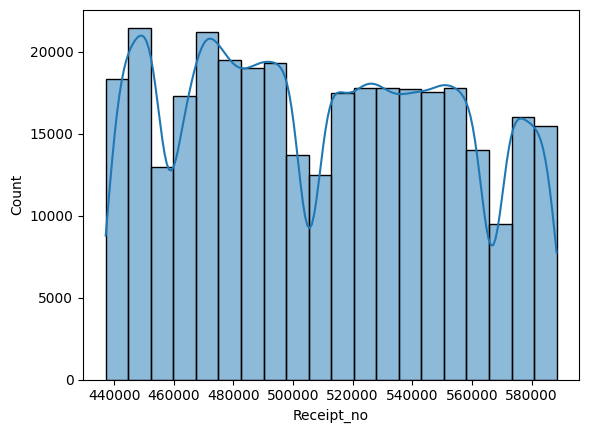

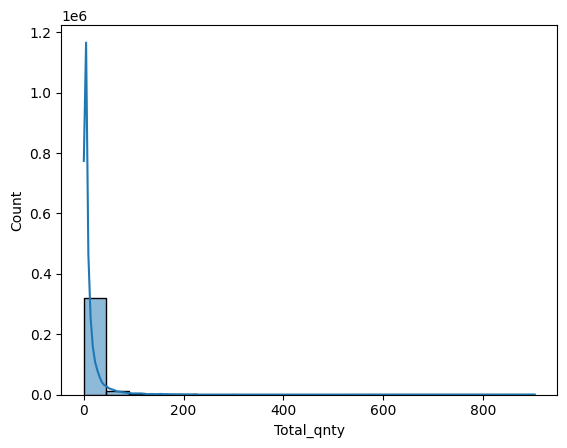

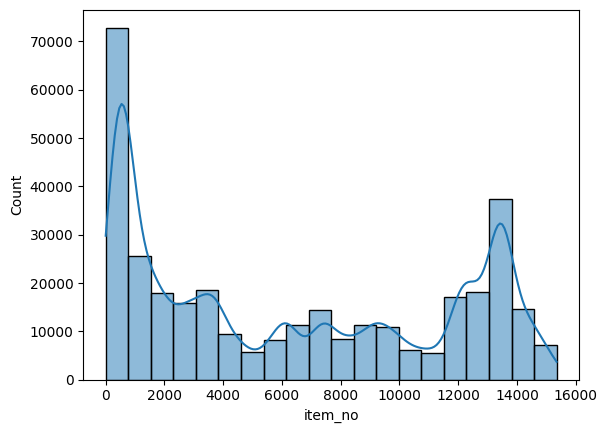

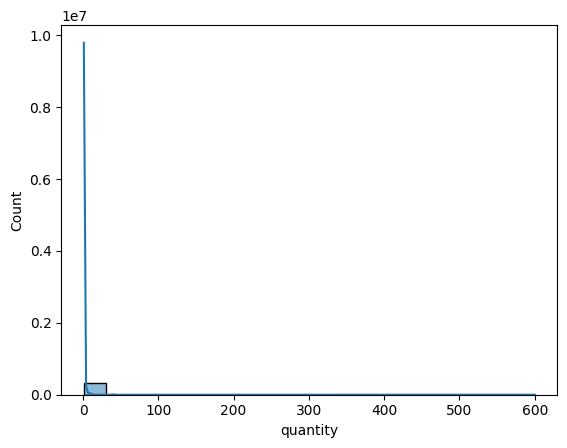

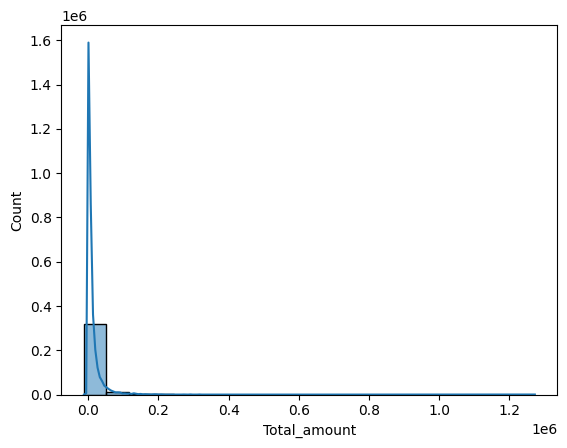

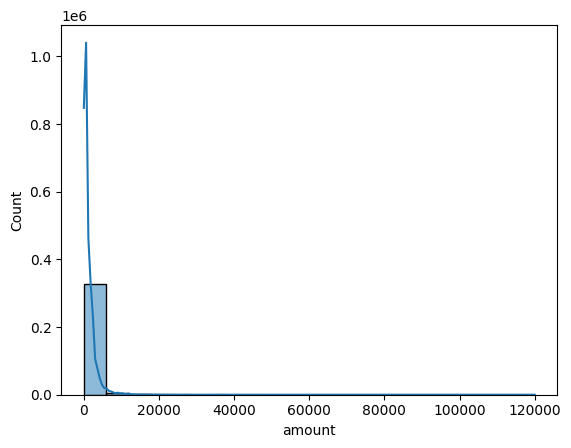

In [ ]:
for field in integer_columns + float_columns:
    sns.histplot(import_df_clean[field], bins=20, kde=True)
    plt.show()
    

Distribution plot of categorical columns

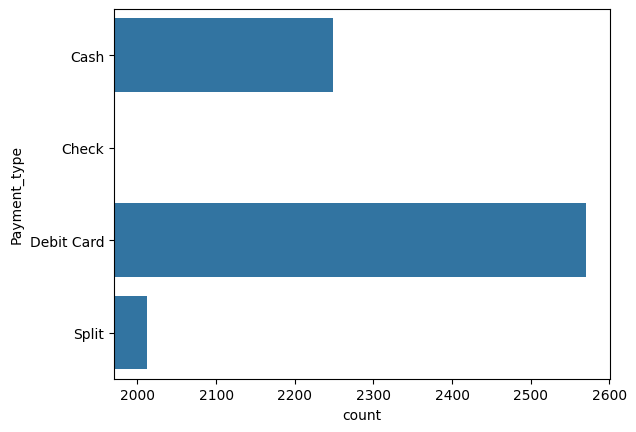

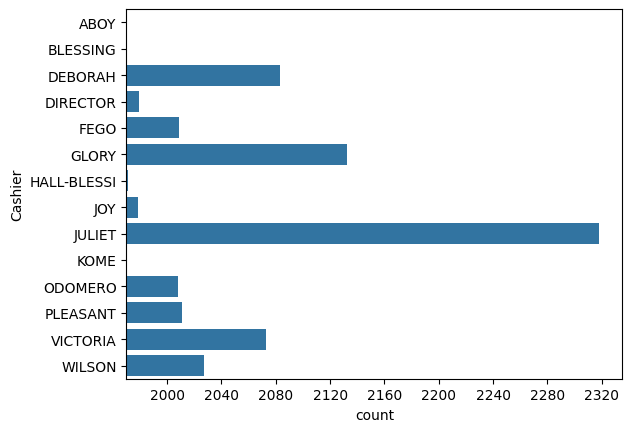

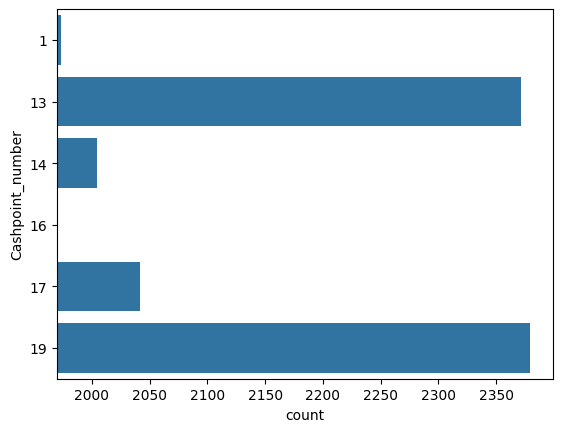

In [ ]:
for field in categorical_columns:
    sns.countplot(import_df_clean[field])
    plt.show()

### TIMESERIES ANALYSIS

Steps to be taken for the time series analysis

- Visualize quantity of items sold and total amount hourly, daily and weekly
- Decompose the time series
- Test for Stationarity

In [69]:
#set the index of the of the cleaned dataframe to datetime
# import_df_clean = import_df_clean.set_index('Datetime')
import_df_clean.head()



,Date,Receipt_no,Receipt_type,Total_qnty,Total_amount,Payment_type,Time,Cashpoint_number,Cashier,item_no,product_name,quantity,amount,Time_24,hour,day,month,year
Datetime,,,,,,,,,,,,,,,,,,
2022-01-12 22:10:31,12/01/2022,437170,Sales,1,600.0,Cash,10:10:31 pm,14,DIRECTOR,8893,KOLAQ ALAGBO BITTERS 200M,1,600.0,22:10:31,22,Wednesday,January,2022
2022-01-12 22:10:08,12/01/2022,437169,Sales,2,470.0,Cash,10:10:08 pm,14,DIRECTOR,1405,COCA COLA PET 60CL,1,170.0,22:10:08,22,Wednesday,January,2022
2022-01-12 22:10:08,12/01/2022,437169,Sales,2,470.0,Cash,10:10:08 pm,14,DIRECTOR,90,MCVITE'S DIGESTIVE 104G,1,300.0,22:10:08,22,Wednesday,January,2022
2022-01-12 22:09:10,12/01/2022,437168,Sales,1,100.0,Cash,10:09:10 pm,14,DIRECTOR,7347,ROENEX SMALLEST PEANUTS,1,100.0,22:09:10,22,Wednesday,January,2022
2022-01-12 22:14:36,12/01/2022,437173,Sales,2,2100.0,Debit Card,10:14:36 pm,14,DIRECTOR,2855,EASY ON SPRAY STARCH NEW,1,1500.0,22:14:36,22,Wednesday,January,2022


#### Visualize quantity of items sold and total amount daily and weekly

Daily trend 

/var/folders/0c/vr9_9rds4t10m_q7fxzlb3x00000gn/T/ipykernel_2307/472742578.py:18: FutureWarning:

The provided callable <built-in function sum> is currently using DatetimeIndexResampler.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



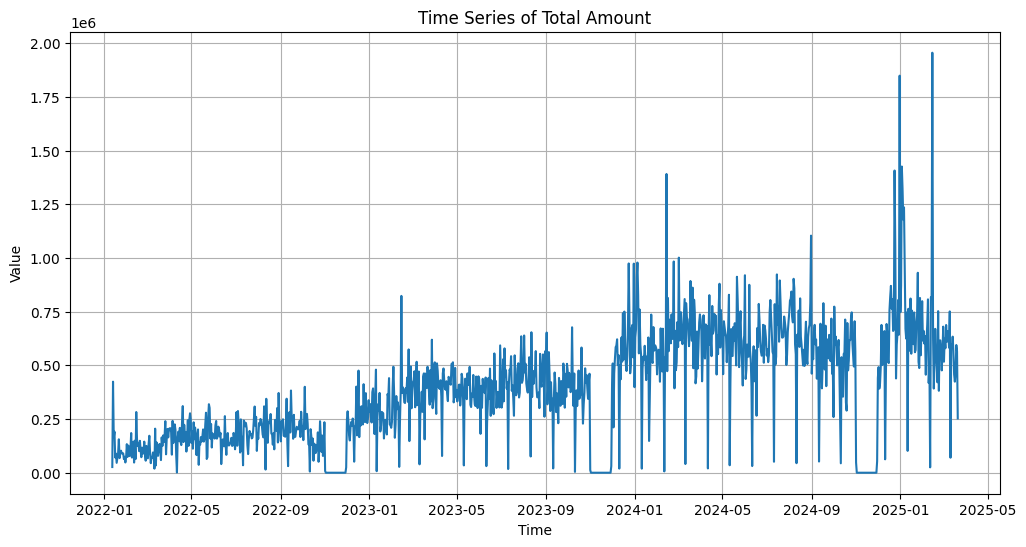

/var/folders/0c/vr9_9rds4t10m_q7fxzlb3x00000gn/T/ipykernel_2307/472742578.py:19: FutureWarning:

The provided callable <built-in function sum> is currently using DatetimeIndexResampler.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



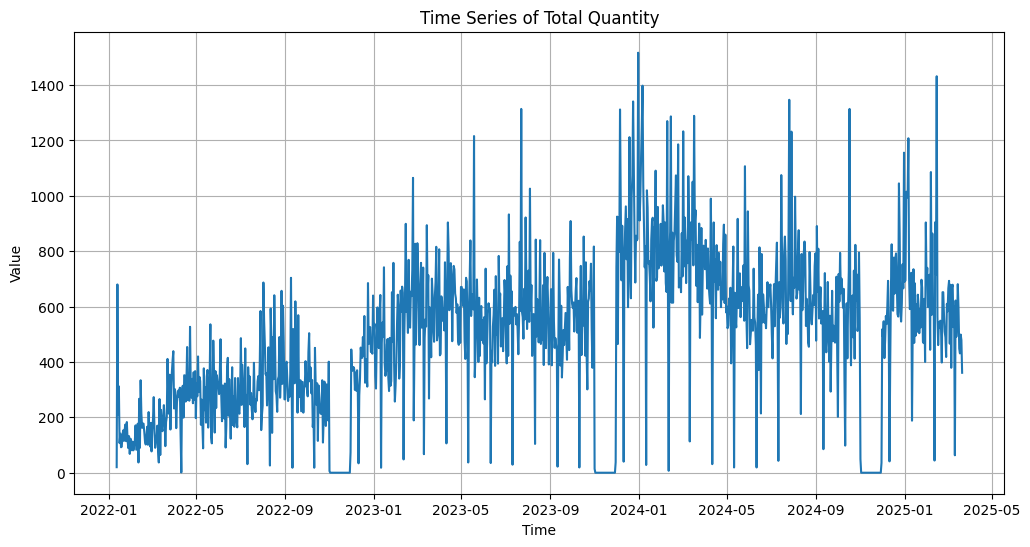

In [ ]:
def plot_time_series(series, title="Time Series Data"):
    plt.figure(figsize=(12, 6))
    plt.plot(series)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

plot_time_series(import_df_clean['amount'].resample('D').apply(sum), title="Time Series of Total Amount")
plot_time_series(import_df_clean['quantity'].resample('D').apply(sum), title="Time Series of Total Quantity")

Weekly Trend

/var/folders/0c/vr9_9rds4t10m_q7fxzlb3x00000gn/T/ipykernel_2307/4180793805.py:10: FutureWarning:

The provided callable <built-in function sum> is currently using DatetimeIndexResampler.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



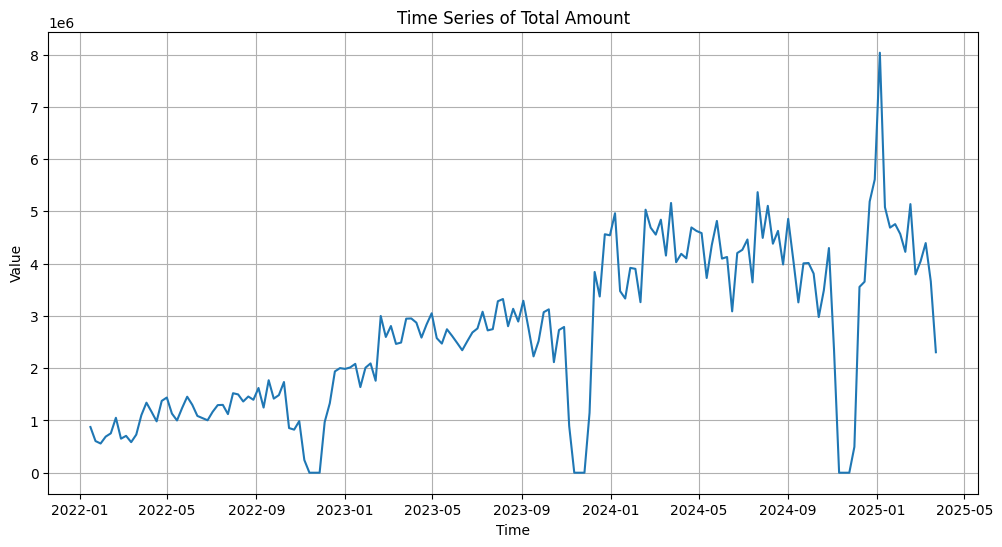

/var/folders/0c/vr9_9rds4t10m_q7fxzlb3x00000gn/T/ipykernel_2307/4180793805.py:11: FutureWarning:

The provided callable <built-in function sum> is currently using DatetimeIndexResampler.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



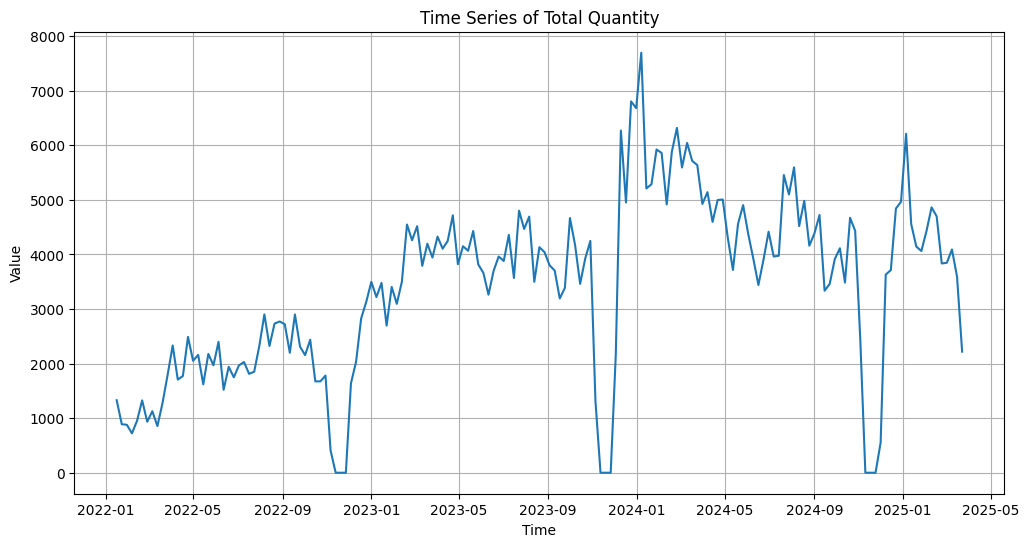

In [101]:
def plot_time_series(series, title="Time Series Data"):
    plt.figure(figsize=(12, 6))
    plt.plot(series)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

plot_time_series(import_df_clean['amount'].resample('W').apply(sum), title="Time Series of Total Amount")
plot_time_series(import_df_clean['quantity'].resample('W').apply(sum), title="Time Series of Total Quantity")

#### Stationarity
Check for the stationarity of the daily amount and quantity sales
- TODO clean up code 

In [112]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[0] < 0.05 and result[0] < result[4]['5%']:
        print('Stationary')
    else:
        print('non stationary')
    print("\n")

# change this to a for loop
print('Test statistics for quantity')
check_stationarity(import_df_clean['quantity'].resample('D').apply(sum))

print('Test statistics for amount')
check_stationarity(import_df_clean['amount'].resample('D').apply(sum))

Test statistics for quantity
ADF Statistic: -3.6828727574545095
p-value: 0.004360616511569534
Critical Values:
   1%: -3.436064032324827
   5%: -2.864063122757945
   10%: -2.5681133731450605
Stationary


Test statistics for amount
ADF Statistic: -3.0154346483573864
p-value: 0.0334779237673674
Critical Values:
   1%: -3.4360342309571053
   5%: -2.864049975956835
   10%: -2.568106371425197
Stationary




/var/folders/0c/vr9_9rds4t10m_q7fxzlb3x00000gn/T/ipykernel_2307/2603164844.py:19: FutureWarning:

The provided callable <built-in function sum> is currently using DatetimeIndexResampler.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.

/var/folders/0c/vr9_9rds4t10m_q7fxzlb3x00000gn/T/ipykernel_2307/2603164844.py:22: FutureWarning:

The provided callable <built-in function sum> is currently using DatetimeIndexResampler.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



Check for the stationarity of the weekly amount and quantity sales

In [113]:
print('Test statistics for quantity')
check_stationarity(import_df_clean['quantity'].resample('W').apply(sum))

print('Test statistics for amount')
check_stationarity(import_df_clean['amount'].resample('W').apply(sum))

Test statistics for quantity
ADF Statistic: -2.226205270117802
p-value: 0.1968722839169515
Critical Values:
   1%: -3.473542528196209
   5%: -2.880497674144038
   10%: -2.576878053634677
non stationary


Test statistics for amount
ADF Statistic: -1.4945144168061137
p-value: 0.5362232120576041
Critical Values:
   1%: -3.473542528196209
   5%: -2.880497674144038
   10%: -2.576878053634677
non stationary




/var/folders/0c/vr9_9rds4t10m_q7fxzlb3x00000gn/T/ipykernel_2307/723516910.py:2: FutureWarning:

The provided callable <built-in function sum> is currently using DatetimeIndexResampler.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.

/var/folders/0c/vr9_9rds4t10m_q7fxzlb3x00000gn/T/ipykernel_2307/723516910.py:5: FutureWarning:

The provided callable <built-in function sum> is currently using DatetimeIndexResampler.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



#### Decomposition


/var/folders/0c/vr9_9rds4t10m_q7fxzlb3x00000gn/T/ipykernel_2307/3503381732.py:35: FutureWarning:

The provided callable <built-in function sum> is currently using DatetimeIndexResampler.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



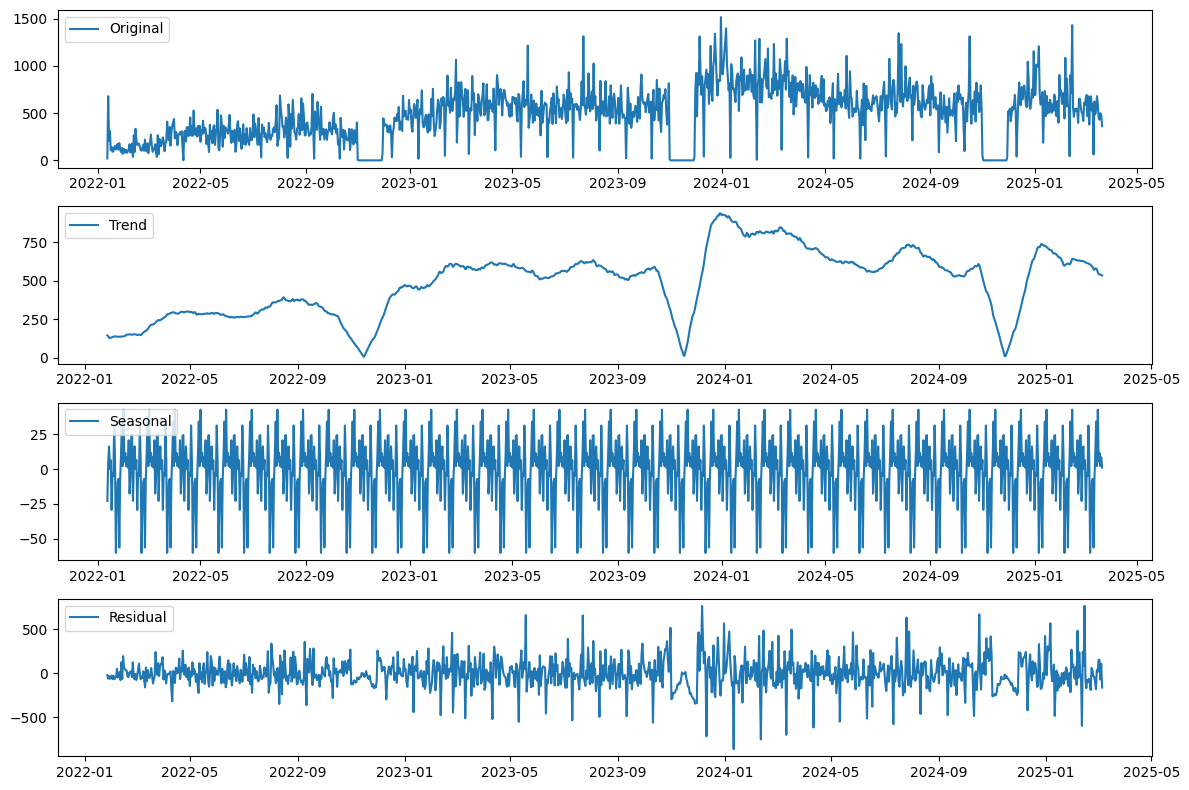

In [59]:


from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_time_series(series, model='additive', period=30):
    """
    Decomposes the time series into trend, seasonal, and residual components.

    Parameters:
    series (pd.Series): The time series data.
    model (str): Type of decomposition model ('additive' or 'multiplicative').
    period (int): The period of the seasonality.
    """
    decomposition = seasonal_decompose(series, model=model, period=period)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(series, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


decompose_time_series(import_df_clean['quantity'].resample('D').apply(sum), model='additive', period=30)

/var/folders/0c/vr9_9rds4t10m_q7fxzlb3x00000gn/T/ipykernel_2307/1998841017.py:1: FutureWarning:

The provided callable <built-in function sum> is currently using DatetimeIndexResampler.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



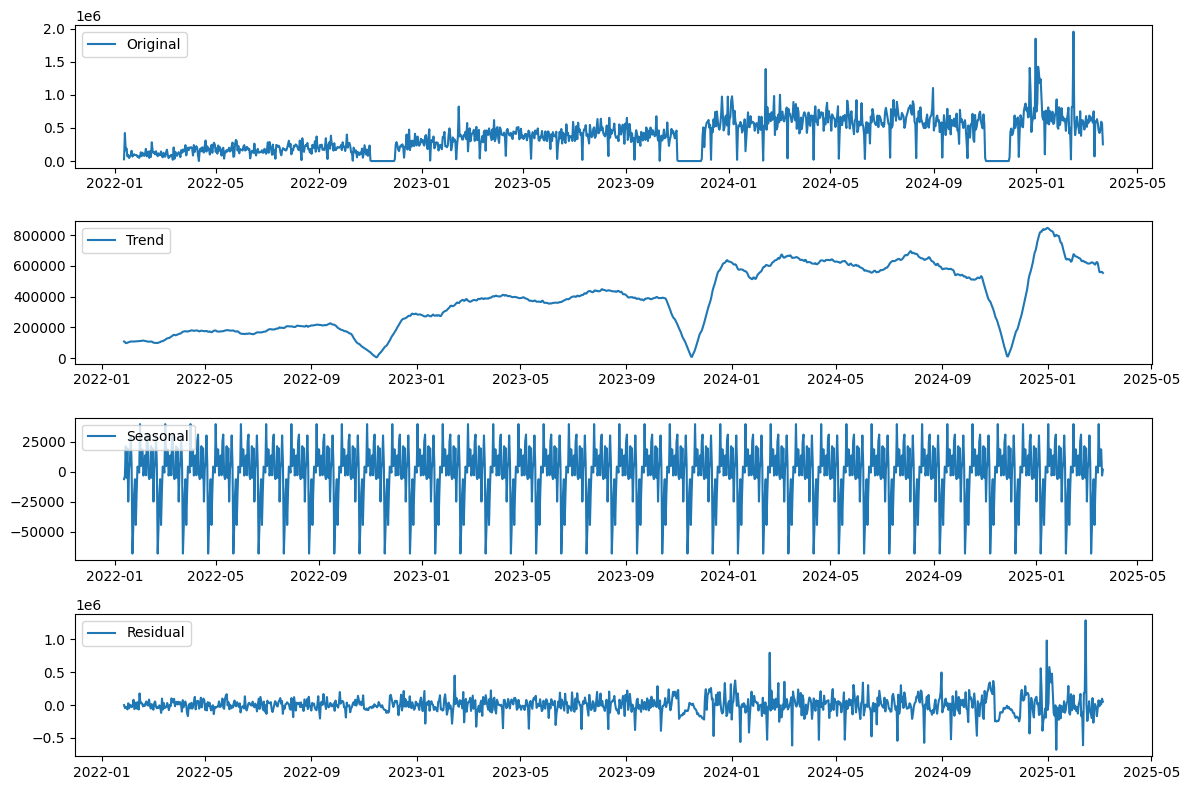

In [104]:
decompose_time_series(import_df_clean['amount'].resample('D').apply(sum), model='additive', period=30)

Decomposition of weekly amount and quantity

/var/folders/0c/vr9_9rds4t10m_q7fxzlb3x00000gn/T/ipykernel_2307/1336696289.py:1: FutureWarning:

The provided callable <built-in function sum> is currently using DatetimeIndexResampler.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



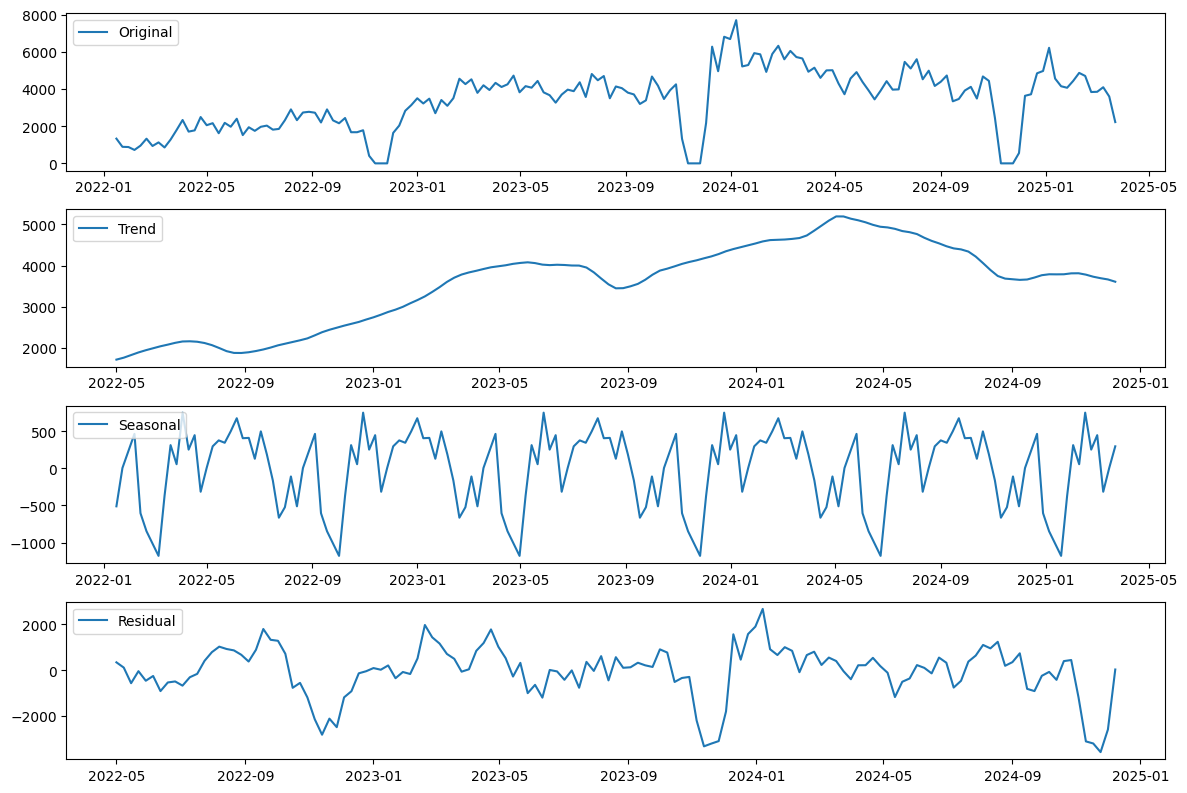

In [105]:
decompose_time_series(import_df_clean['quantity'].resample('W').apply(sum), model='additive', period=30)

/var/folders/0c/vr9_9rds4t10m_q7fxzlb3x00000gn/T/ipykernel_2307/1419429544.py:1: FutureWarning:

The provided callable <built-in function sum> is currently using DatetimeIndexResampler.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



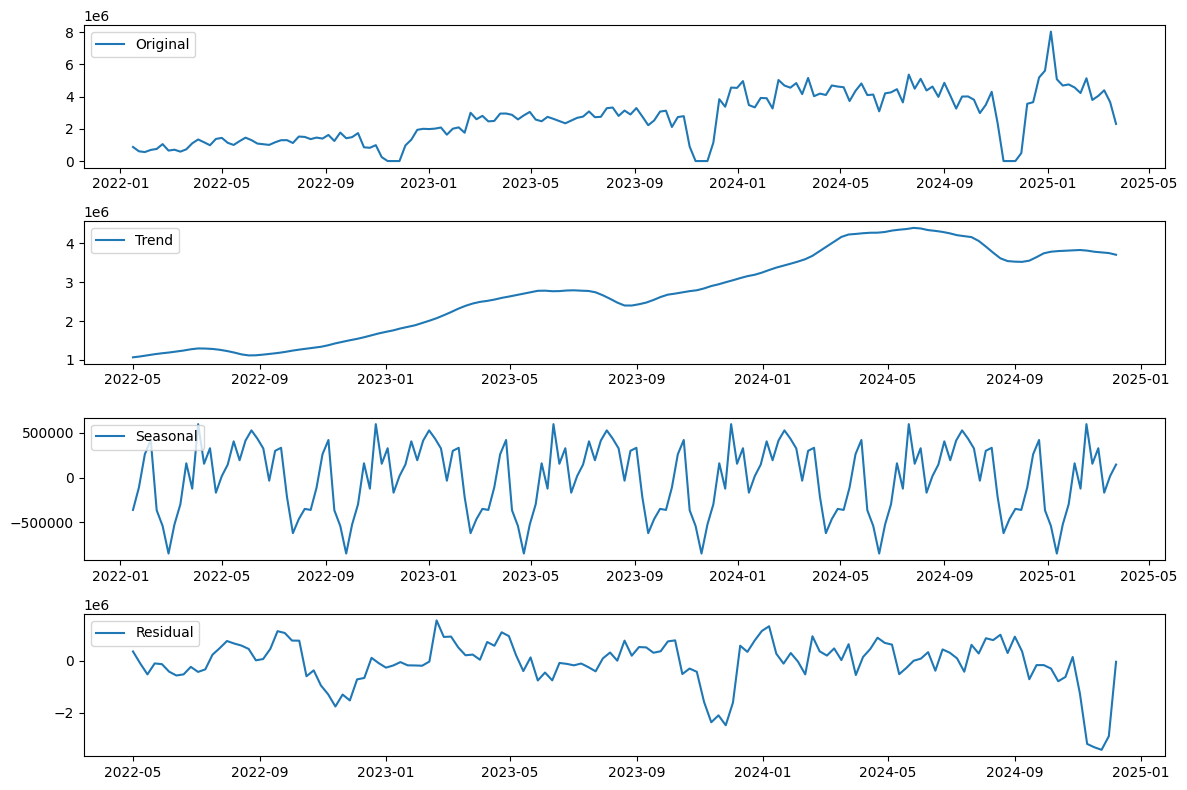

In [106]:
decompose_time_series(import_df_clean['amount'].resample('W').apply(sum), model='additive', period=30)

# MODEL DEVELOPMENT 

#### Steps taken:
- Feature engineering to resample the data to daily, forecast will be done for amount sold
- Train and Test split
- ARIMA model using auto arima to get best model 
- Facebook Prophet
- LSTM
- Hyperparameter tuning of best model

##### Resample amount sold to daily

In [81]:
daily_amount = import_df_clean['amount'].resample('D').sum()
print(daily_amount)

Datetime
2022-01-12     26500.0000
2022-01-13    423864.0000
2022-01-14    162351.0000
2022-01-15    190979.0000
2022-01-16     70805.0000
                 ...     
2025-03-17    423950.0000
2025-03-18    468685.3125
2025-03-19    594540.0000
2025-03-20    564730.0000
2025-03-21    252846.0000
Freq: D, Name: amount, Length: 1165, dtype: float32


### TRAIN TEST SPLIT

In [82]:
# Split data into training and testing using the date.
split_date = '2024-09-01 00:00:00'
X = daily_amount.copy() 
X_train = X.loc[X.index <= split_date]
X_test = X.loc[X.index > split_date]
print(f' shape of train: {X_train.shape}, test: {X_test.shape}, maximum date of the train: {X_train.index.max()}, test: {X_test.index.max()}')

 shape of train: (964,), test: (201,), maximum date of the train: 2024-09-01 00:00:00, test: 2025-03-21 00:00:00


In [83]:
X_train.tail()

Datetime
2024-08-28    6.738193e+05
2024-08-29    6.887000e+05
2024-08-30    7.912300e+05
2024-08-31    1.103797e+06
2024-09-01    4.611700e+05
Freq: D, Name: amount, dtype: float32

In [84]:
X_test.tail()

Datetime
2025-03-17    423950.0000
2025-03-18    468685.3125
2025-03-19    594540.0000
2025-03-20    564730.0000
2025-03-21    252846.0000
Freq: D, Name: amount, dtype: float32

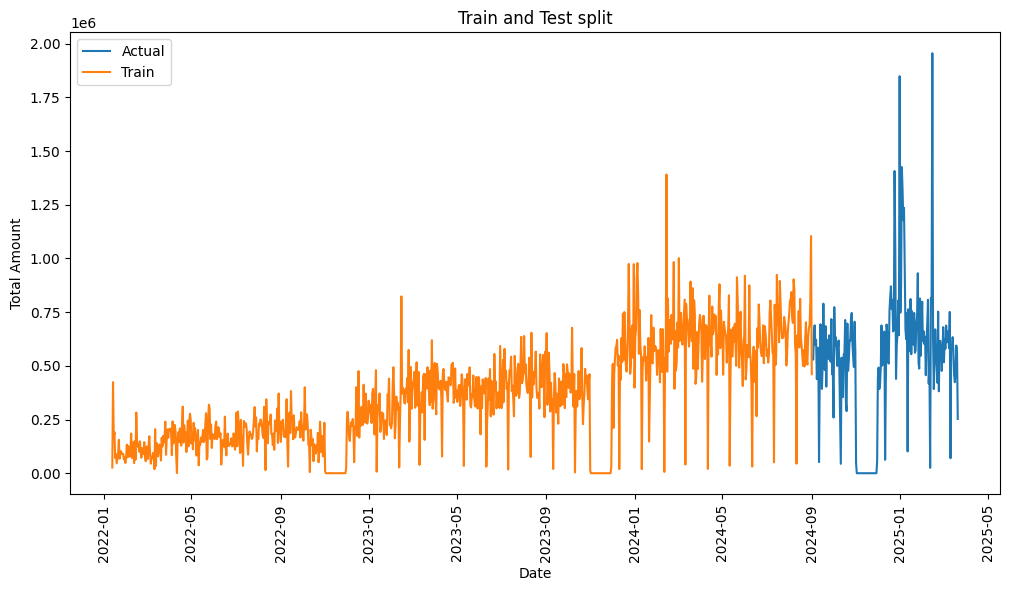

In [109]:
plt.figure(figsize=(12, 6))
plt.plot(X_test, label='Actual')
plt.plot(X_train, label='Train')
plt.title('Train and Test split')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.legend()
plt.xticks(rotation=90)
plt.show()

### ARIMA


Plot the Partial Auto Correlation and Auto correlation.


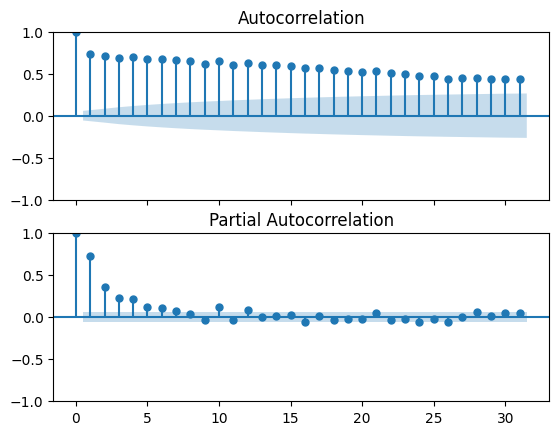

In [89]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, squeeze=True)
plot_acf(X, ax=ax1)
plot_pacf(X, method='ywm',ax=ax2)
plt.show()

/Users/okundiakessy/Documents/All-things-Python/BritonandKayMLprojects/BritonandkayMLprojects/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/okundiakessy/Documents/All-things-Python/BritonandKayMLprojects/BritonandkayMLprojects/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/okundiakessy/Documents/All-things-Python/BritonandKayMLprojects/BritonandkayMLprojects/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA RMSE: 357447.2593660919


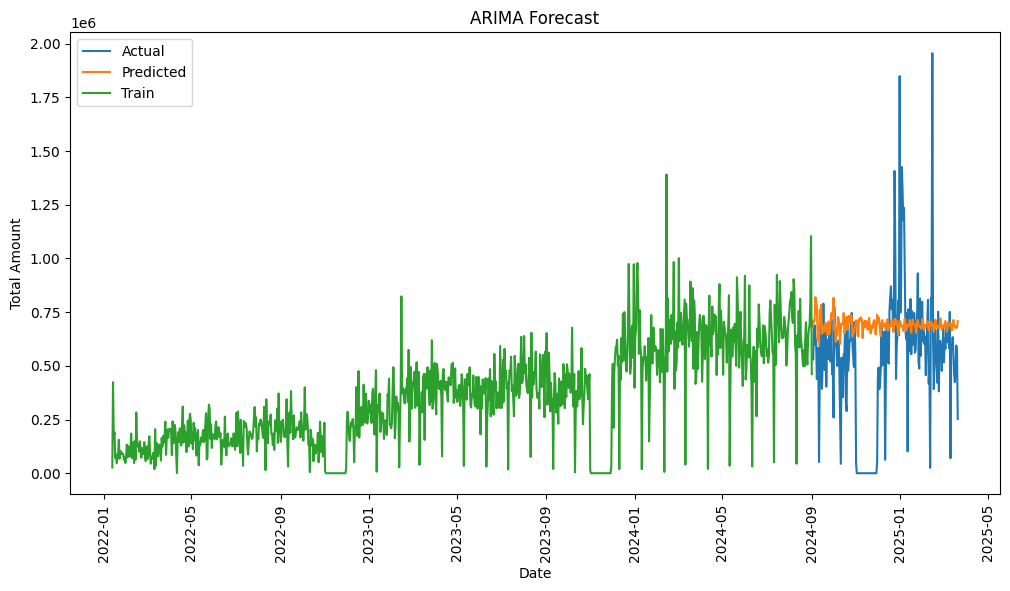

In [115]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt


# Define the ARIMA model
model = ARIMA(X_train, order=(30, 0, 30))  # Example order, tune as needed
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(X_test))

# Evaluate the model
rmse = np.sqrt(mean_squared_error(X_test, predictions))
print(f'ARIMA RMSE: {rmse}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(X_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.plot(X_train, label='Train')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.legend()
plt.xticks(rotation=90)
plt.show()

### PROPHET

Train a baseline prophet model with default parameters for total quantity sold.

In [122]:
# Assuming import_df_clean is your preprocessed DataFrame
X_train_prophet = X_train
X_train_prophet = X_train_prophet.reset_index().rename(columns={'Datetime': 'ds', 'amount': 'y'})
X_train_prophet.head()


,ds,y
0,2022-01-12,26500.0
1,2022-01-13,423864.0
2,2022-01-14,162351.0
3,2022-01-15,190979.0
4,2022-01-16,70805.0


In [123]:
# Train prohet model
model = Prophet()
model.fit(X_train_prophet)

09:24:14 - cmdstanpy - INFO - Chain [1] start processing
09:24:15 - cmdstanpy - INFO - Chain [1] done processing


Test prophet model


In [125]:
#Convert Test Data set to desirable format
X_test_prophet = X_test
X_test_prophet = X_test_prophet.reset_index().rename(columns={'Datetime': 'ds', 'amount': 'y'})
X_test_prophet.head()

,ds,y
0,2024-09-02,544536.6250
1,2024-09-03,528623.3125
2,2024-09-04,657956.6250
3,2024-09-05,688423.3125
4,2024-09-06,597450.0625


In [126]:
#predict with the trained model using cleaned up test data
prediction = model.predict(X_test_prophet)

In [132]:
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-09-02,641247.810706,476318.740094,769266.209868,641247.810706,641247.810706,-16059.710901,-16059.710901,-16059.710901,-16422.336560,-16422.336560,-16422.336560,362.625660,362.625660,362.625660,0.0,0.0,0.0,625188.099805
1,2024-09-03,641874.317073,492619.430263,802553.695793,641874.317073,641874.317073,3590.116234,3590.116234,3590.116234,2408.818277,2408.818277,2408.818277,1181.297957,1181.297957,1181.297957,0.0,0.0,0.0,645464.433307
2,2024-09-04,642500.823440,471047.296437,808101.489772,642500.823440,642500.823440,-720.701725,-720.701725,-720.701725,-2847.792758,-2847.792758,-2847.792758,2127.091033,2127.091033,2127.091033,0.0,0.0,0.0,641780.121715
3,2024-09-05,643127.329807,494787.712721,793321.717878,643127.329807,643127.329807,-274.119528,-274.119528,-274.119528,-3420.181839,-3420.181839,-3420.181839,3146.062311,3146.062311,3146.062311,0.0,0.0,0.0,642853.210279
4,2024-09-06,643753.836174,525858.733976,837736.415914,643753.836174,643753.836174,39311.182978,39311.182978,39311.182978,35129.603817,35129.603817,35129.603817,4181.579160,4181.579160,4181.579160,0.0,0.0,0.0,683065.019151


In [140]:
#convert peredictions to a series
prediction = prediction.set_index(prediction['ds'])
prophet_prediction = pd.Series(prediction['yhat'])
print(prophet_prediction)

ds
2024-09-02    625188.099805
2024-09-03    645464.433307
2024-09-04    641780.121715
2024-09-05    642853.210279
2024-09-06    683065.019151
                  ...      
2025-03-17    821114.817775
2025-03-18    841065.036296
2025-03-19    836902.256852
2025-03-20    837379.608386
2025-03-21    876919.534328
Name: yhat, Length: 201, dtype: float64


Prophet Forecast: 227504.65208430355


ValueError: x and y can be no greater than 2D, but have shapes (232,) and (232, 7, 1)

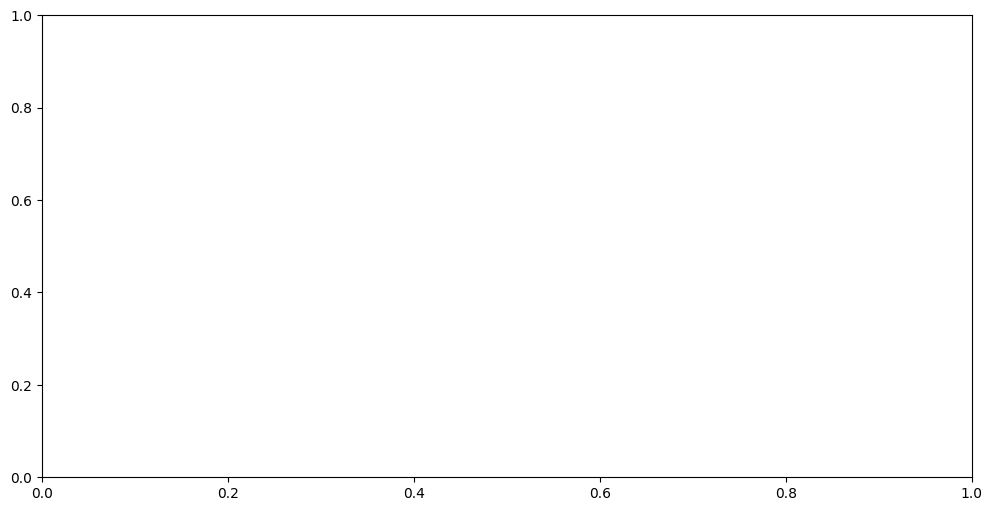

In [154]:
# Evaluate the model
#rmse = np.sqrt(mean_squared_error(X_test, prediction['yhat']))
print(f'Prophet Forecast: {rmse}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(X_test, label='Actual')
plt.plot(prophet_prediction, label='Predicted')
#plt.plot(X_train, label='Train')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.legend()
plt.xticks(rotation=90)
plt.show()

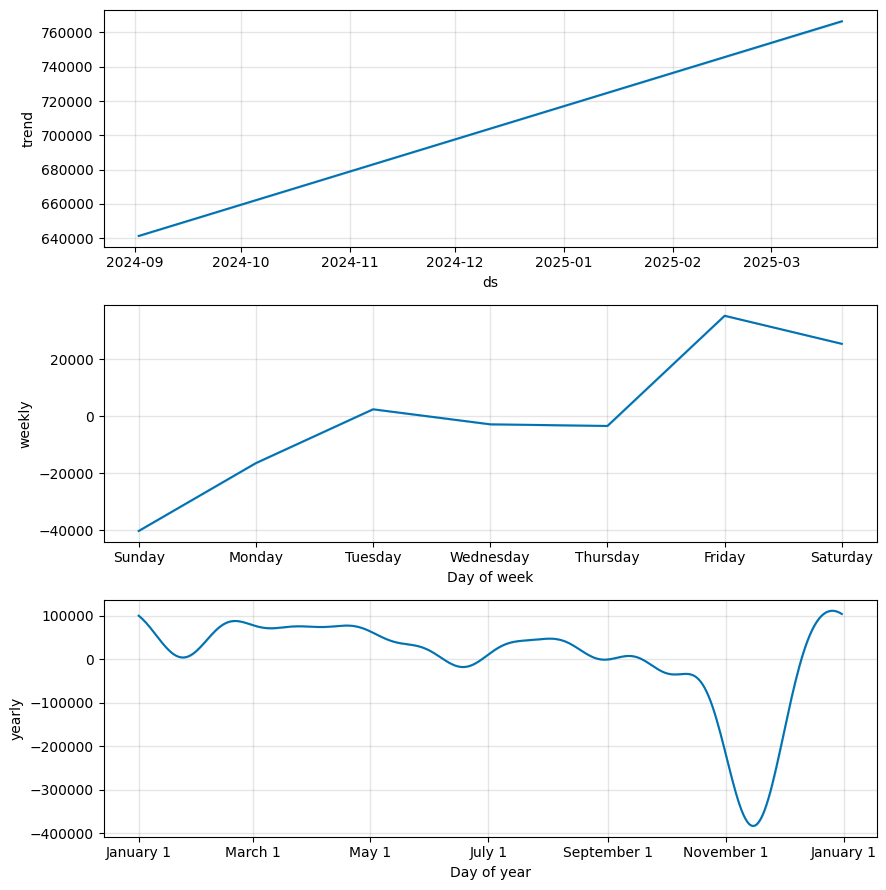

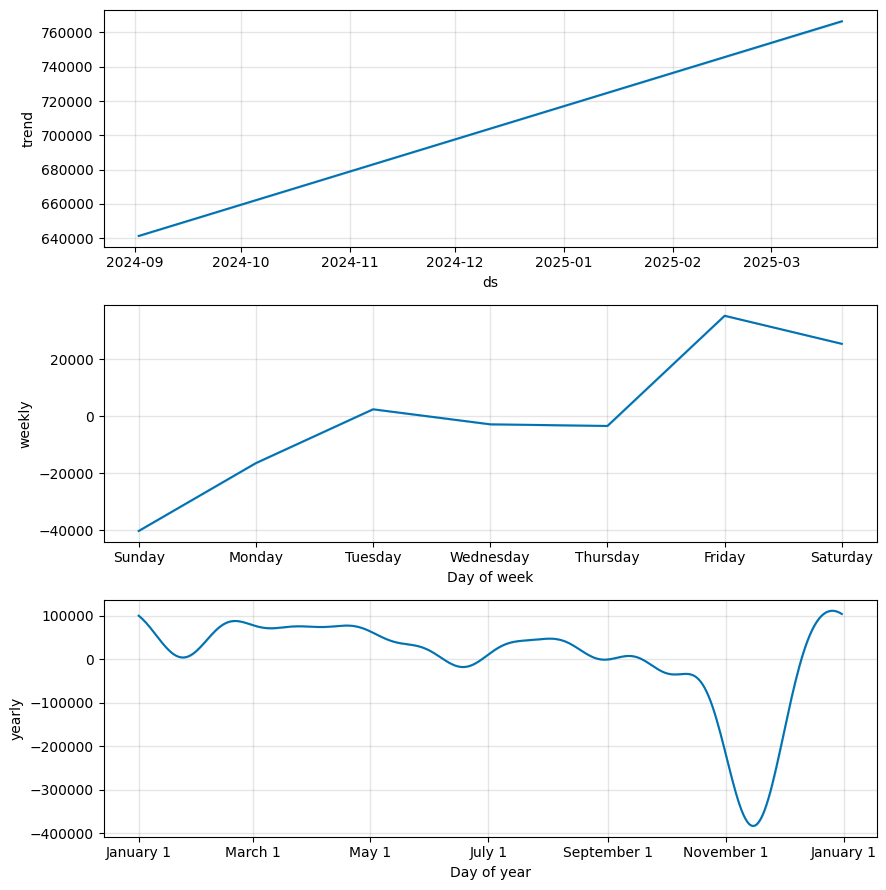

In [142]:
model.plot_components(prediction)

Evaluate baseline Prophet prediction

In [146]:
# Evaluate the model using root mean square error
prophet_baseline_total_qnty = np.sqrt(mean_squared_error(
	y_true=X_test_prophet['y'], 
	y_pred=prediction['yhat']
))
print(prophet_baseline_total_qnty)

285650.10217539745


In [148]:
X_test.describe()

count    2.010000e+02
mean     5.247198e+05
std      3.179576e+05
min      0.000000e+00
25%      4.239500e+05
50%      5.680970e+05
75%      6.695900e+05
max      1.955241e+06
Name: amount, dtype: float64

In [144]:
def calculate_mape(y_true, y_pred):
    """
    Calculates the Mean Absolute Percentage Error (MAPE).

    Parameters:
    y_true (array-like): Array of actual values.
    y_pred (array-like): Array of predicted values.

    Returns:
    float: MAPE value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Avoid division by zero
    y_true = np.where(y_true == 0, 1e-8, y_true)
    
    absolute_percentage_errors = np.abs((y_true - y_pred) / y_true)
    mape = np.mean(absolute_percentage_errors) * 100
    return mape

# Assuming X_test_prophet['y'] and prediction['yhat'] are available
mape_score = calculate_mape(X_test_prophet['y'], prediction['yhat'])
print(f"MAPE: {mape_score:.2f}%")

MAPE: 510100572583439.94%


### LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Prepare data for LSTM
def create_sequences(data, look_back=7):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

# Use daily_amount as the target series (ensure it's a pandas Series)
series = daily_amount.values.reshape(-1, 1)

# Scale data
scaler = RobustScaler()
series_scaled = scaler.fit_transform(series)

# Create sequences
look_back = 7
X, y = create_sequences(series_scaled, look_back=look_back)

# Train/test split (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(look_back, 1)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predict and inverse transform
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae = mean_absolute_error(y_test_inv, y_pred)
print(f"LSTM RMSE: {rmse:.2f}")
print(f"LSTM MAE: {mae:.2f}")


Epoch 1/100


/Users/okundiakessy/Documents/All-things-Python/BritonandKayMLprojects/BritonandkayMLprojects/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2225 - val_loss: 0.2598
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0882 - val_loss: 0.2562
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0970 - val_loss: 0.2184
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0903 - val_loss: 0.2126
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0679 - val_loss: 0.2536
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0787 - val_loss: 0.2324
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0836 - val_loss: 0.2144
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0782 - val_loss: 0.2308
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0721 - val_loss: 0.2989
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0730 - val_loss: 0.2217
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0772 - val_loss: 0.2178
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0682 - val_lo

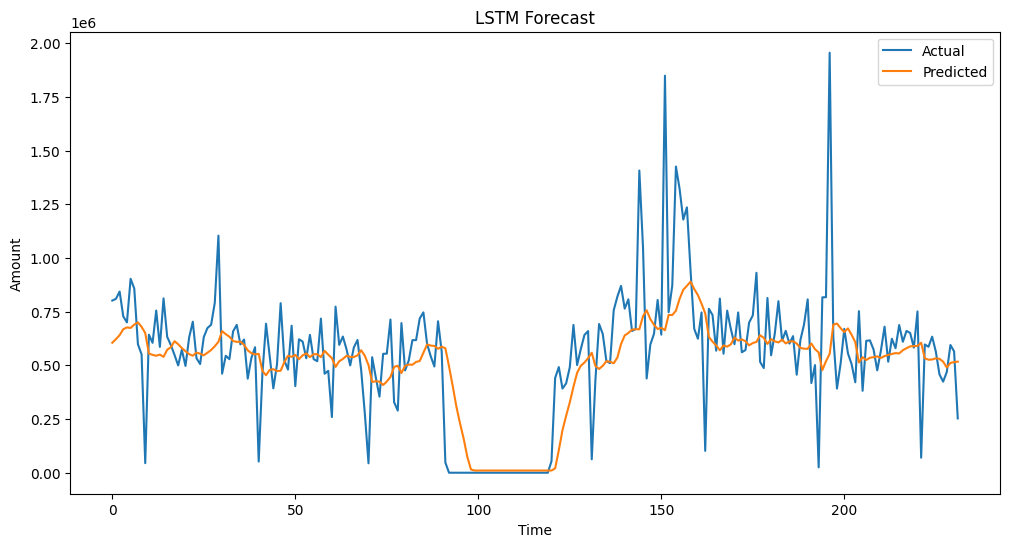

In [ ]:
# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred, label='Predicted')
#plt.plot(X_train, label='Train data')
plt.title('LSTM Forecast')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend()
plt.show()


#### Hypoerparameter tuning